In [1]:
import os
import google.generativeai as genai
from dotenv import load_dotenv
load_dotenv()
from langchain_core.runnables import RunnableLambda, RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages import BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver


c:\Users\vishw\OneDrive\Desktop\Langgraph\langgraph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
GOOGLE_API_KEY = os.getenv("GOOGLE_GEMINI_API")

In [39]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [40]:
graph_builder = StateGraph(State)

In [41]:

tool = TavilySearchResults(max_results=2)
tools = [tool]



In [42]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro-latest",  # or "gemini-pro" for the older version
    temperature=0.3,
    google_api_key=GOOGLE_API_KEY 
)


In [43]:
### Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

In [44]:
def chatbot(state: State):
    # Use the tool-bound LLM here
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [45]:
graph_builder.add_node("chatbot",chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

In [46]:
import json
from langchain_core.messages import ToolMessage

In [47]:
class BasicToolNode:
     """A node that runs the tools requested in the last AIMessage."""

     def __init__(self,tools:list) ->None:
          self.tools_by_name = {tool.name:tool for tool in tools}

     def __call__(self,inputs:dict):
          if messages := inputs.get("messages", []):
            message = messages[-1]
          else:
            raise ValueError("No message found in input")  
          
          outputs=[]

          for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
            return {"messages": outputs}
          
          
        
               



In [48]:
tool_node = BasicToolNode(tools = [tool])
graph_builder.add_node("tools",tool_node)

Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not.

In [49]:
def route_tools(
        state:State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """

    if isinstance(state,list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]

    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END
    
    



In [50]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

In [51]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

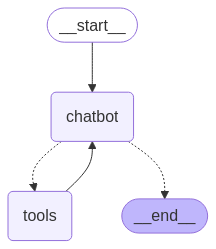

In [52]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [53]:
def stream_graph_updates(user_input: str):
    try:
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
            for value in event.values():
                if "messages" in value and value["messages"]:  # Check if messages exist
                    last_message = value["messages"][-1]
                    if hasattr(last_message, "content"):  # Check for content attribute
                        print("Assistant:", last_message.content)
                    else:
                        print("Assistant:", str(last_message))  # Fallback
    except Exception as e:
        print(f"Error: {str(e)}")  # Better error handling




In [54]:
while True:
    try:
        user_input = input("User: ").strip()
        if not user_input:
            user_input = "What do you know about LangGraph?"  # Default if empty
            print(f"User: {user_input}")
            
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
            
        stream_graph_updates(user_input)
    except Exception:
        user_input = "What do you know about LangGraph?"
        print(f"User: {user_input}")
        stream_graph_updates(user_input)
        break  # Remove this if you want to continue after fallback

User: What do you know about LangGraph?
Assistant: 
Assistant: [{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] [](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-21-6)   LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). It's particularly useful for creating agent and multi-agent workflows.\n[](https://langchain-a